In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

In [2]:
data=pd.read_csv("~/Downloads/COVID19-clean_pivot.csv")

In [3]:
data.head()

,Date,Country,State,County,Confirmed_Cumulative,Deaths_Cumulative,Confirmed,Deaths
0,1/22/2020,China,Anhui,None,1,0,1,0
1,1/22/2020,China,Beijing,None,14,0,14,0
2,1/22/2020,China,Chongqing,None,6,0,6,0
3,1/22/2020,China,Fujian,None,1,0,1,0
4,1/22/2020,China,Guangdong,None,26,0,26,0


In [4]:
data=data.drop('County', axis=1)

In [5]:
data=data.drop('Confirmed', axis=1)

In [6]:
data=data.drop('Deaths', axis=1)

In [7]:
data.head()

,Date,Country,State,Confirmed_Cumulative,Deaths_Cumulative
0,1/22/2020,China,Anhui,1,0
1,1/22/2020,China,Beijing,14,0
2,1/22/2020,China,Chongqing,6,0
3,1/22/2020,China,Fujian,1,0
4,1/22/2020,China,Guangdong,26,0


In [8]:
data=data.rename(columns={"Date": "date", "Country": "country", "State": "state","Confirmed_Cumulative":"confirm","Deaths_Cumulative": "death"})

In [9]:
data.head()

,date,country,state,confirm,death
0,1/22/2020,China,Anhui,1,0
1,1/22/2020,China,Beijing,14,0
2,1/22/2020,China,Chongqing,6,0
3,1/22/2020,China,Fujian,1,0
4,1/22/2020,China,Guangdong,26,0


In [18]:
def plot_predict(country, stat, future_days):
    
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)
    
    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        value = c / (1 + np.exp(-b*(x-a)))
        #print(value)
        return (c / (1 + np.exp(-b*(x-a))))
    
    inception = 0
    # hardcoding day 0 for several countries based on observations
    if country=="South Korea": inception = 8
    if country=="US": inception = 28
    if country=="Italy": inception = 20
        
    country_data = data[data["country"]==country].iloc[: , [0, 2, 3 ,4]].copy() 
    country_data['date'] = pd.to_datetime(country_data["date"])
    country_data['date']=country_data['date'].dt.date
    country_graph = country_data.groupby("date")[['confirm', 'death']].sum().reset_index()[inception:]
    #country_graph['date']=pd.to_datetime(country_graph["date"],format='%m/%d/%Y')
    #print(country_graph)
    #country_graph=country_graph.set_index("date")
    country_graph=country_graph.sort_values(by=['date'])
    #country_graph=country_graph['date'].dt.strftime('%m/%d/%Y')
    country_graph.style.format({"date": lambda t: t.strftime("%m/%d/%Y")})
    print(country_graph)
    
    y = country_graph[stat]
    x = np.arange(len(y))
    #print("Ymax")
    #print(y.max)
    # fitting the data on the logistic function
    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox', bounds=([12., 0.001, y.mean()],[60., 2.5, 10*y.max()]))
    #popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox', bounds=([12., 0.001, 15000],[60., 2.5, 10*15000]))
    #popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox')
    print(popt_sig)
    print(pcov_sig)
    
    #peakday = datetime.strptime(country_graph["date"][inception], "%Y/%m/%d")+timedelta(days=int(popt_sig[0]))
    peakday = country_graph["date"][inception]+timedelta(days=int(popt_sig[0]))
    print(peakday)
    plt.figure(figsize=(16,8))
    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)
    
    print("Predictions:")
    for i in range(1,10):
        #pday = datetime.strftime(datetime.strptime(country_graph["date"][inception], "%m/%d/%Y")+timedelta(days=len(y)+i-1), "%m/%d/%Y")
        pday =country_graph["date"][inception]+timedelta(days=len(y)+i-1)
        print("%s: %d" % (pday, y_m[len(y)+i-1]))
    
    #country_graph.head(40)
    #print(country_graph)
    
    # creating the matplotlib visualization
    plt.plot(x_m, y_m, c='k', marker="x", label="sigmoid | error: "+str(avg_err(pcov_sig))) 
    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
    
    plt.plot(x, y, c='r', marker="o", label = stat)
    plt.xlabel("Days")
    plt.ylabel("Total Infected")
    plt.legend(prop={'size': 15})
    plt.title(country+"'s Confirmed Cases", size=15)
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[-1], str(country_graph["date"][len(y)+inception-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    peakday=str(peakday)
    plt.text(int(popt_sig[0]), 1, "peak: day " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 20)
    plt.savefig('corona_confirmed.png')
    plt.show()

In [19]:
def plot_predict_death(country, stat, future_days):
    
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)
    
    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        value = c / (1 + np.exp(-b*(x-a)))
        #print(value)
        return (c / (1 + np.exp(-b*(x-a))))
    
    inception = 0
    # hardcoding day 0 for several countries based on observations
    if country=="South Korea": inception = 8
    if country=="US": inception = 28
    if country=="Italy": inception = 20
        
    country_data = data[data["country"]==country].iloc[: , [0, 2, 3 ,4]].copy() 
    country_data['date'] = pd.to_datetime(country_data["date"])
    country_data['date']=country_data['date'].dt.date
    country_graph = country_data.groupby("date")[['confirm', 'death']].sum().reset_index()[inception:]
    #country_graph['date']=pd.to_datetime(country_graph["date"],format='%m/%d/%Y')
    #print(country_graph)
    #country_graph=country_graph.set_index("date")
    country_graph=country_graph.sort_values(by=['date'])
    #country_graph=country_graph['date'].dt.strftime('%m/%d/%Y')
    country_graph.style.format({"date": lambda t: t.strftime("%m/%d/%Y")})
    print(country_graph)
    
    y = country_graph[stat]
    x = np.arange(len(y))
    #print("Ymax")
    #print(y.max)
    # fitting the data on the logistic function
    #popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox', bounds=([12., 0.001, y.mean()],[60., 2.5, 10*y.max()]))
    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox', bounds=([12., 0.001, 15000],[60., 2.5, 10*15000]))
    #popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method='dogbox')
    print(popt_sig)
    print(pcov_sig)
    
    #peakday = datetime.strptime(country_graph["date"][inception], "%Y/%m/%d")+timedelta(days=int(popt_sig[0]))
    peakday = country_graph["date"][inception]+timedelta(days=int(popt_sig[0]))
    print(peakday)
    plt.figure(figsize=(16,8))
    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)
    
    print("Predictions:")
    for i in range(1,10):
        #pday = datetime.strftime(datetime.strptime(country_graph["date"][inception], "%m/%d/%Y")+timedelta(days=len(y)+i-1), "%m/%d/%Y")
        pday =country_graph["date"][inception]+timedelta(days=len(y)+i-1)
        print("%s: %d" % (pday, y_m[len(y)+i-1]))
    
    #country_graph.head(40)
    #print(country_graph)
    
    # creating the matplotlib visualization
    plt.plot(x_m, y_m, c='k', marker="x", label="sigmoid | error: "+str(avg_err(pcov_sig))) 
    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
    
    plt.plot(x, y, c='r', marker="o", label = stat)
    plt.xlabel("Days")
    plt.ylabel("Total Infected")
    plt.legend(prop={'size': 15})
    plt.title(country+"'s Deaths", size=15)
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[-1], str(country_graph["date"][len(y)+inception-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    peakday=str(peakday)
    #plt.text(int(popt_sig[0]), 1, "peak: day " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 20)
    plt.savefig('corona_death.png')
    plt.show()

          date  confirm  death
28  2020-02-19       13      0
29  2020-02-20       13      0
30  2020-02-21       15      0
31  2020-02-22       15      0
32  2020-02-23       15      0
33  2020-02-24       15      0
34  2020-02-25       15      0
35  2020-02-26       15      0
36  2020-02-27       16      0
37  2020-02-28       16      0
38  2020-02-29       24      1
39  2020-03-01       30      1
40  2020-03-02       53      6
41  2020-03-03       73      7
42  2020-03-04      104     11
43  2020-03-05      172     12
44  2020-03-06      217     14
45  2020-03-07      336     17
46  2020-03-08      450     21
47  2020-03-09      514     22
48  2020-03-10      708     28
49  2020-03-11     1105     32
50  2020-03-12     1557     40
51  2020-03-13     2147     48
52  2020-03-14     2857     52
53  2020-03-15     2918     60
54  2020-03-16     4287     84
55  2020-03-17     6028    107
56  2020-03-18     8805    143
57  2020-03-19    14025    208
58  2020-03-20    19331    257
59  2020

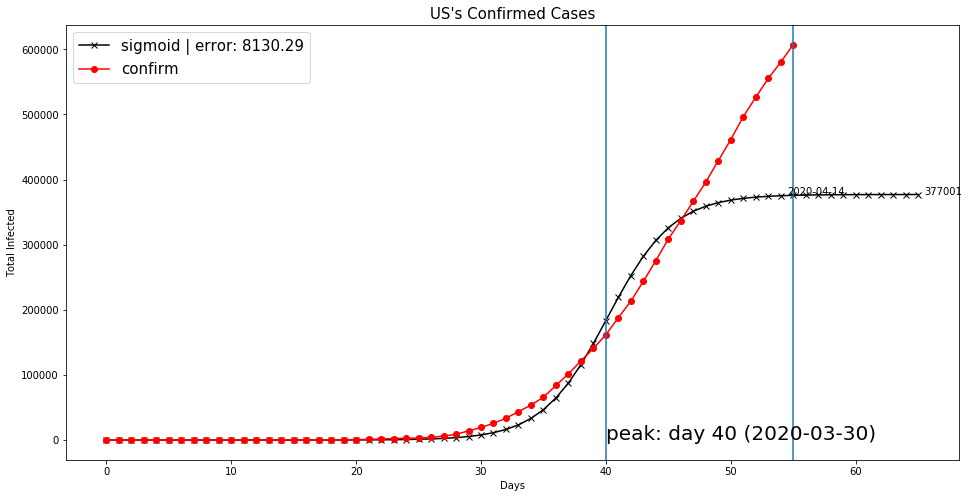

In [20]:
plot_predict("US", "confirm", 10)

          date  confirm  death
28  2020-02-19       13      0
29  2020-02-20       13      0
30  2020-02-21       15      0
31  2020-02-22       15      0
32  2020-02-23       15      0
33  2020-02-24       15      0
34  2020-02-25       15      0
35  2020-02-26       15      0
36  2020-02-27       16      0
37  2020-02-28       16      0
38  2020-02-29       24      1
39  2020-03-01       30      1
40  2020-03-02       53      6
41  2020-03-03       73      7
42  2020-03-04      104     11
43  2020-03-05      172     12
44  2020-03-06      217     14
45  2020-03-07      336     17
46  2020-03-08      450     21
47  2020-03-09      514     22
48  2020-03-10      708     28
49  2020-03-11     1105     32
50  2020-03-12     1557     40
51  2020-03-13     2147     48
52  2020-03-14     2857     52
53  2020-03-15     2918     60
54  2020-03-16     4287     84
55  2020-03-17     6028    107
56  2020-03-18     8805    143
57  2020-03-19    14025    208
58  2020-03-20    19331    257
59  2020

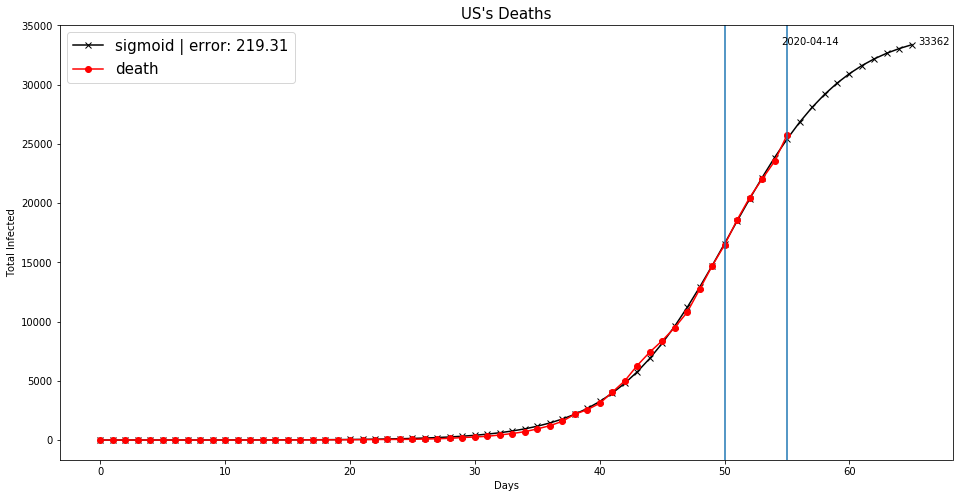

In [17]:
plot_predict_death("US", "death", 10)

[1.20000000e+01 5.46691837e-01 7.35962320e+04]
Predictions:
04/08/2020: 73596
04/09/2020: 73596
04/10/2020: 73596
04/11/2020: 73596
         date  confirm  death
0   1/22/2020      548     17
1   1/23/2020      643     18
2   1/24/2020      920     26
3   1/25/2020     1406     42
4   1/26/2020     2075     56
..        ...      ...    ...
72   4/3/2020    82511   3326
73   4/4/2020    82543   3330
74   4/5/2020    82602   3333
75   4/6/2020    82665   3335
76   4/7/2020    82718   3335

[77 rows x 3 columns]


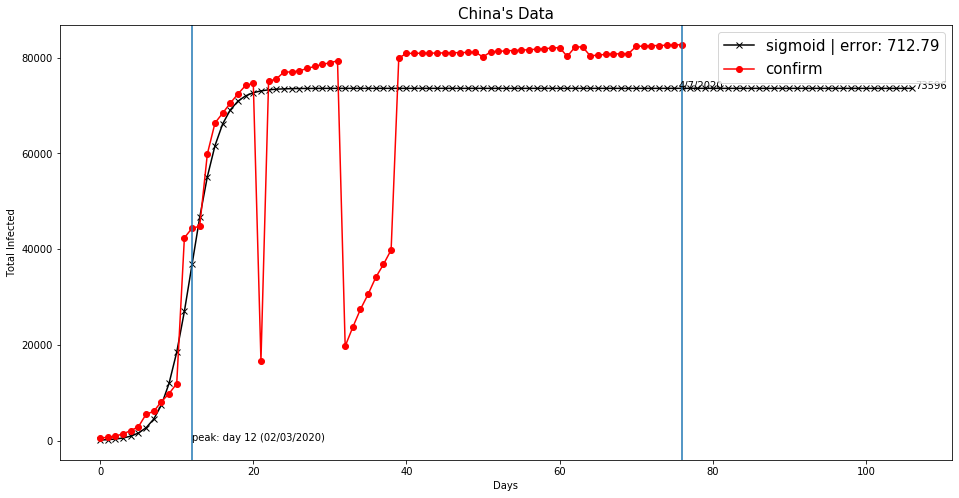

In [38]:
plot_predict("China", "confirm", 30)